## Part 3. Feature Visualization for SVHN
SVHN is a real-world image dataset for developing machine learning and object recognition algorithms with minimal requirement on data preprocessing and formatting. It can be seen as similar in flavor to MNIST (e.g., the images are of small cropped digits), but incorporates an order of magnitude more labeled data (over 600,000 digit images) and comes from a significantly harder, unsolved, real world problem (recognizing digits and numbers in natural scene images). SVHN is obtained from house numbers in Google Street View images. 
(http://ufldl.stanford.edu/housenumbers/)

In [1]:
import tensorflow as tf
from tensorflow.python.platform import gfile
import numpy as np
import scipy.io as sio
import scipy.misc
import math
import pickle
from random import randint
import os
import os.path
from datetime import datetime
from matplotlib import pyplot as plt

### 1. Preparing the tools

#### (i) Define Data Functions 

In [2]:
def GCN(data_dir, ratio):
    ''' Perform image transformation Global Contraction Nornimlization 
    
    Arguments:
    ----------
        data_dir: the path to the SVHN, the data is in .mat format
        ratio: test and train ratio
        
    Return: 
    ----------
        images after GCN transformation
    '''
    
    train_data = sio.loadmat(data_dir)
    x_train = train_data['X']
    y_train = train_data['y']
    y_train[y_train == 10] = 0
    x_train = x_train.transpose((3,0,1,2))
    x_train.astype(float)
    x_gray = np.dot(x_train, [[0.2989],[0.5870],[0.1140]])

    imsize = x_gray.shape[0]
    mean = np.mean(x_gray, axis=(1,2), dtype=float)
    std = np.std(x_gray, axis=(1,2), dtype=float, ddof=1)
    std[std < 1e-4] = 1
    x_GCN = np.zeros(x_gray.shape, dtype=float)
    for i in np.arange(imsize):
        x_GCN[i,:,:] = (x_gray[i,:,:] - mean[i]) / std[i]
    nums = x_GCN.shape[0]
    x_GCN = x_GCN.reshape((nums,-1))
    data = np.hstack((y_train,x_GCN))
    np.random.shuffle(data)
    cut=math.floor(nums*ratio)
    val,train = data[:cut,:], data[cut:,:]

    print("\n------- GCN done -------")
    return train, val

In [3]:
def read_SVHN(data_dir, ratio, batch_size):
    ''' read SCVN function images are 32 * 32 and in gray scale 
    
    Args:
    ----------
        data_dir: the path to the SVHN, the data is in .mat format
        ratio: test and train ratio
        batch_size: number of train images trained per time
        
    Return:
    ----------
        image_list: the first element of image_list is 
                    the train batch the second is the validation batch
        label_list: the first element of label_list is 
                    the train batch the second is the validation batch
    '''
    train,val = GCN(data_dir, ratio)
    img_width = 32
    img_height = 32
    img_depth = 1
    label_bytes = 1
    image_bytes = 1024
    record_bytes = 1025

    with tf.name_scope('input'):
        images_list = []
        label_batch_list = []
        for train_val in [train, val]:
            q = tf.train.input_producer(train_val)
            input_data = q.dequeue()

            label = tf.slice(input_data , [0], [1])
            label = tf.cast(label, tf.int32)

            image_raw = tf.slice(input_data , [1], [1024])
            image_raw = tf.reshape(image_raw, [1, 32, 32])
            image = tf.transpose(image_raw, (1,2,0))
            image = tf.cast(image, tf.float32)
            images, label_batch = tf.train.batch([image, label],
                                                batch_size = batch_size,
                                                num_threads = 16,
                                                capacity= 2000)

            n_classes = 10
            label_batch = tf.one_hot(label_batch, depth = n_classes)

            label_batch_list.append(tf.reshape(label_batch,
                                               [batch_size, n_classes]))
            images_list.append(images)


        return images_list, label_batch_list

#### (ii) Define CNN Helper Functions 

In [4]:
def conv(layer_name, x, out_channels, kernel_size=[5,5], stride=[1,1,1,1]):
    '''Convolution op wrapper, use RELU activation after convolution
    
    Args:
    ----------
        layer_name: e.g. conv1, pool1...
        x: input tensor, [batch_size, height, width, channels]
        out_channels: number of output channels (or comvolutional kernels)
        kernel_size: the size of convolutional kernel, VGG paper used: [3,3]
        stride: A list of ints. 1-D of length 4. VGG paper used: [1, 1, 1, 1]
        is_pretrain: if load pretrained parameters, freeze all conv layers.
                     Depending on different situations, 
                    you can just set part of conv layers to be freezed.
        the parameters of freezed layers will not change when training.
        
    Returns:
    ----------
        4D tensor
    '''

    in_channels = x.get_shape()[-1]
    with tf.variable_scope(layer_name):
        w = tf.get_variable(name='weights',
                            shape=[kernel_size[0],
                                   kernel_size[1],
                                   in_channels, out_channels],
                            initializer=tf.contrib.layers.xavier_initializer())
        # default is uniform distribution initialization
        b = tf.get_variable(name='biases',
                            shape=[out_channels],
                            initializer=tf.constant_initializer(0.0))
        x = tf.nn.conv2d(x, w, stride, padding='SAME', name='conv')
        x = tf.nn.bias_add(x, b, name='bias_add')
        x = tf.nn.relu(x, name='relu')
        return x
    
    
def pool(layer_name, x, kernel=[1,2,2,1], stride=[1,2,2,1]):
    '''Pooling operation
    
    Args:
    ----------
        x: input tensor
        kernel: pooling kernel, VGG paper used [1,2,2,1], the size of kernel is 2X2
        stride: stride size, VGG paper used [1,2,2,1]
        padding:'SAME'
    '''
    with tf.variable_scope(layer_name):
        x = tf.nn.max_pool(x, kernel, strides=stride, padding='SAME', name=layer_name)
        return x

def FC_layer(layer_name, x, out_nodes):
    '''Wrapper for fully connected layers with RELU activation as default
    
    Args:
    ----------
        layer_name: e.g. 'FC1', 'FC2'
        x: input feature map
        out_nodes: number of neurons for current FC layer
    '''
    shape = x.get_shape()
    size = shape[1].value * shape[2].value * shape[3].value

    with tf.variable_scope(layer_name):
        w = tf.get_variable('weights',
                            shape=[size, out_nodes],
                            initializer=tf.contrib.layers.xavier_initializer())
        b = tf.get_variable('biases',
                            shape=[out_nodes],
                            initializer=tf.constant_initializer(0.0))
        flat_x = tf.reshape(x, [-1, size]) # flatten into 1D

        x = tf.nn.bias_add(tf.matmul(flat_x, w), b)
        x = tf.nn.relu(x)
        return x
    
def final_layer(layer_name, x, out_nodes):
    '''Wrapper for fully connected layers without activation function
    
    Args:
    ----------
        layer_name: e.g. 'final_layer'
        x: input feature map
        out_nodes: number of neurons for current FC layer
    '''
    shape = x.get_shape()
    size = shape[-1].value
    with tf.variable_scope(layer_name):
        w = tf.get_variable('weights',
                            shape=[size, out_nodes],
                            initializer=tf.contrib.layers.xavier_initializer())
        b = tf.get_variable('biases',
                            shape=[out_nodes],
                            initializer=tf.constant_initializer(0.0))
        flat_x = tf.reshape(x, [-1, size]) # flatten into 1D
        x = tf.nn.bias_add(tf.matmul(flat_x, w), b)
        return x

    
def drop_out(layer_name, x, keep_prob = 0.5):
    '''Wrapper for drop_out layer
    
    Args:
    ----------
        layer_name: e.g. 'drop_out'
        x: input feature map
        kep_prob: the prob of a specific neuron is inactive 
        for the next layer
    '''    
    with tf.variable_scope(layer_name):
        x = tf.nn.dropout(x, keep_prob)
        return x

    
def lossFn(logits, labels):
    '''Lost function
    
    Args: 
    ----------
        logits: Logits tensor, float - [batch_size, NUM_CLASSES].
        labels: Labels tensor
        
    Returns: 
    ----------
        loss tensor
    '''
    
    with tf.variable_scope('loss') as scope:
        labels = tf.cast(labels, tf.int64)
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits
                        (logits=logits, labels=labels, name='loss')
        loss = tf.reduce_mean(cross_entropy, name='loss')
        tf.summary.scalar(scope.name+'/loss', loss)
    return loss


def accuracyFn(logits, labels):
    """Evaluate the quality of the logits at predicting the label.
    
    Args:
    ----------
        logits: Logits tensor, float - [batch_size, NUM_CLASSES].
        labels: Labels tensor
        
    Returns:
    ----------
        accuracy tensor
    """
    with tf.name_scope('accuracy') as scope:
        correct = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
        correct = tf.cast(correct, tf.float32)
        accuracy = tf.reduce_mean(correct)*100.0
        tf.summary.scalar(scope+'/accuracy', accuracy)
        
    return accuracy

def optimize(loss, learning_rate, global_step):
    '''optimization use AdamOptimizer
    
    Args:
    ----------
        loss: Loss tensor
        learning_rate: e10-4 is desired 
        global_step: non trainable varible
        
    Returns:
    ----------
        train_op: train operation 
    '''
    with tf.name_scope('optimizer'):
    # optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        train_op = optimizer.minimize(loss, global_step=global_step)
        return train_op

#### (iii)  Define Visualizing Functions 

In [5]:
def unpool(value, name='unpool'):
    """N-dimensional version of the unpooling operation from
    https://www.robots.ox.ac.uk/~vgg/rg/papers
    /Dosovitskiy_Learning_to_Generate_2015_CVPR_paper.pdf
    
    args:
    ----------
    A Tensor of shape [b, d0, d1, ..., dn, ch]
    
    return:
    ----------
    A Tensor of shape [b, 2*d0, 2*d1, ..., 2*dn, ch]
    """
    with tf.name_scope(name) as scope:
        shape = value.get_shape().as_list()
        dim = len(shape[1:-1])
        out = (tf.reshape(value, [-1] + shape[-dim:]))
        for i in range(dim, 0, -1):
            out = tf.concat([out, out],i)
        out_size = [-1] + [s * 2 for s in shape[1:-1]] + [shape[-1]]
        out = tf.reshape(out, out_size, name=scope)
    return out

In [20]:
def display_features(v_name, pool_size, out_shape, p_v, figs, col_mp):
    """
    Use unpooling and deconvolution to visualize features 
    with stored activation values
    
    args:
    ----------
    v_name = variable name of the conv/weight of the desired layer
    pool_size = size of the 4D tensor that comes out of the layer
    out_shape = size of the 4D tensor that goes into the layer
    figs = size of the output image
    col_mp = gray or rbd color mapping
    
    return:
    ----------
    Image of features of the specified layer
    """
    
    w = [v for v in tf.trainable_variables() if v.name == v_name][0]
    
    #Reconstruction from the layer CNV-1
    featuresReLu = tf.placeholder(tf.float32, pool_size)
    unPool = unpool(featuresReLu)
    unReLu = tf.nn.relu(unPool)
    unBias  = unReLu
    unConv = tf.nn.conv2d_transpose(unBias, w,
                                    output_shape=out_shape ,
                                    strides=[1,1,1,1], padding="SAME")
    
    plt.figure(figsize=(2.5*figs[0],2.5*figs[1]))
    for i in range(figs[0]*figs[1]):
        isolated = p_v.copy()
        isolated[:,:,:,:i] = 0
        isolated[:,:,:,i+1:] = 0 
        #These two lines set all other features other than feature i to 0
        totals = np.sum(isolated,axis=(1,2,3))
        best = np.argmax(totals,axis=0) 
        #Picking the one image from this batch of images 
        #which feacture i can judge best.
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            pixelactive = sess.run(unConv, feed_dict={featuresReLu: isolated})
        #print(pixelactive.shape) 
        plt.subplot(figs[0],figs[1],i+1)    
        plt.imshow(pixelactive[best,:,:,0],cmap = col_mp)
        plt.title('Feature_{}'.format(i+1))
        plt.axis('off') 
    plt.subplots_adjust(top=0.5, bottom=0.08, left=0.10,
                        right=0.95, hspace=0.5, wspace=0.35)
    plt.show()

### 2. CNN Model Training
5 layers: 2 feature selection layers + fully connection + dropout + softmax

#### (i) Setting parameters 

In [7]:
N_CLASSES = 10
IMG_W =  32
# resize the image, 
#if the input image is too large, training will be very slow.
IMG_H = 32
RATIO = 0.1 # take 20% of dataset as validation data
BATCH_SIZE = 64
TEST_BATCH_SIZE = 20
CAPACITY = 2000
MAX_STEP = 10000
# with current parameters, it is suggested to use MAX_STEP>10k
learning_rate = 0.0001 
# with current parameters, it is suggested to use learning rate<0.0001

data_dir = './data/SVHN/train_32x32.mat'
train_log_dir = './logs/SVHN/train'
val_log_dir = './logs/SVHN/val'

#### (ii) Training the model

In [ ]:
with tf.name_scope('input'):

    image_batch, label_batch  = read_SVHN(data_dir = data_dir,
                                                        ratio = 0.1,
                                                        batch_size = 64)
    tra_image_batch = image_batch[0]
    tra_label_batch = label_batch[0]

    val_image_batch = image_batch[1]
    val_label_batch = label_batch[1]


x = tf.placeholder(tf.float32, shape=[BATCH_SIZE, IMG_W, IMG_H, 1])
y_ = tf.placeholder(tf.int16, shape=[BATCH_SIZE,N_CLASSES])


c1 = conv('conv1', x, 16)
p1 = pool('pool1', c1)

c2 = conv('conv2', p1, 64)
p2 = pool('pool2', c2)

c3 = conv('conv3', p2, 128)
p3 = pool('pool3', c3)

fc = FC_layer('fc4', p3, out_nodes = 64)
do = drop_out('drop_out', fc, keep_prob = 0.5)
logits = final_layer('softmax', do, out_nodes=N_CLASSES)

loss = lossFn(logits, y_)
accuracy = accuracyFn(logits, y_)

my_global_step = tf.Variable(0, name='global_step', trainable=False)
train_op = optimize(loss, learning_rate, my_global_step)
summary_op = tf.summary.merge_all()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    tra_summary_writer = tf.summary.FileWriter(train_log_dir, sess.graph)
    val_summary_writer = tf.summary.FileWriter(val_log_dir, sess.graph)


    try:
        for step in np.arange(MAX_STEP):
            if coord.should_stop():
                break
            tra_images,tra_labels = sess.run([tra_image_batch, tra_label_batch])
            _, tra_loss, tra_acc = sess.run([train_op, loss, accuracy],
                                            feed_dict={x:tra_images, y_:tra_labels})
            
            if step % 5 == 0 or (step + 1) == MAX_STEP:

                print ('Step: %d, loss: %.4f, accuracy: %.4f%%'
                       % (step, tra_loss, tra_acc))
                _, summary_str = sess.run([train_op, summary_op],
                                          feed_dict={x: tra_images, y_: tra_labels})
                tra_summary_writer.add_summary(summary_str, step)

            if step % 5 == 0 or (step + 1) == MAX_STEP:
                val_images, val_labels = sess.run([val_image_batch, val_label_batch])
                val_loss, val_acc = sess.run([loss, accuracy],
                                             feed_dict={x:val_images,y_:val_labels})

                print('**Step %d, val loss = %.2f, val accuracy = %.2f%%**' 
                      %(step, val_loss, val_acc))
                _, summary_str = sess.run([train_op, summary_op],
                                          feed_dict={x: val_images, y_: val_labels})
                val_summary_writer.add_summary(summary_str, step)
            
            if step == (MAX_STEP - 1):
                c1_v = sess.run(c1, feed_dict={x:tra_images})
                p1_v = sess.run(p1, feed_dict={c1:c1_v})
                c2_v = sess.run(c2, feed_dict={p1:p1_v})
                p2_v = sess.run(p2, feed_dict={c2:c2_v})
                c3_v = sess.run(c3, feed_dict={p2:p2_v})
                p3_v = sess.run(p3, feed_dict={c3:c3_v})

    except tf.errors.OutOfRangeError:
        print('Done training -- epoch limit reached')

    finally:
        coord.request_stop()
    coord.join(threads)

<img src="https://raw.githubusercontent.com/bpeng93/CNN_Feature_Visualization/master/fig/output-SVHN.png" style="zoom:100%" />
Because the number of training step is 10000, it may occurpy too many pages. We use a screen shots to present the result.

#### (iii) SVHN Model Structure
<img src="https://raw.githubusercontent.com/bpeng93/CNN_Feature_Visualization/master/fig/SVHN_tensorboard_train_graphs.png" style="zoom:100%" />

#### (iv) SVHN Model Performance

Train Set
<img src="https://raw.githubusercontent.com/bpeng93/CNN_Feature_Visualization/master/fig/1.jpg" style="zoom:100%" />
<br><br><br>
<img src="https://raw.githubusercontent.com/bpeng93/CNN_Feature_Visualization/master/fig/2.jpg" style="zoom:100%" />
Test Set




### 3. Deconvolution Feature Visualization

We stored the activation values of one batch of images during the training session, after they undergo each layer. We now feed the stored activations, along with the conv/weights, into the unpooling and unconvoluting operations that we have defined above. 

These operations project the activations back onto the 2D image space, with each 2D image correspond to each feature. We then respresent each feature by the image from this batch of images which the feacture can judge best.

By its nature, layers that are made up by convolution and pooling are intended to 'encode' the inputs, in the sense that they record certain information of the inputs, and while doing so, also discard some other information. 

By visualizing the features, we attempt to see what these 'encoders' decide to record and what do they decide to discard.

#### (i) Reconstruction From The First Convolutional Layer (batch)
After Layer 1: 16 features, each of size 16x16

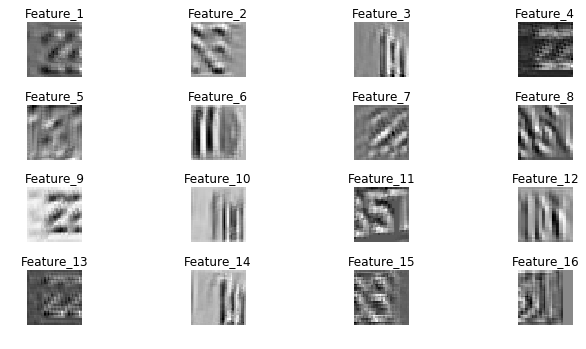

In [22]:
display_features(
                v_name = "conv1/weights:0", 
                pool_size = [None, 16,16,16],
                out_shape = [64,32,32,1],
                p_v = p1_v,
                figs = (4,4), 
                col_mp="gray")

After the first feature selection layer, each input image of size 32x32 gets transformed into a stack of 16 feature layers, each of size 16x16. For each of the 16 features, we visualize it by picking the one image (from the stored 64 image batch) that the feature judges best. As could be seen from the pictures, the features after the first layer do not deviate from the original input by far. <br>

* ** Grouping: ** <br>
<br>
Group 1a: Feature 1, 4, 9, 13. They work best on the 'twisting' 2-digit house numbers (such as 22 and 33) on the right side of the image. <br>
Group 1b: Feature 2, 15. Similar to group 1, they work best on the 'twisting' 2-digit house numbers on the left side. <br>
<br>
Group 2a: Feature 3, 10, 14. They work best on the 'vertical' 2-digit house numbers (such as 11) on the right side of the image. <br>
Group 2b: Feature 6. Similar to group 4, it works best on the 'vertical' 2-digit house numbers on the left side.<br>
<br>
Group 3: Feature 5, 8, 11, 12. They work best on 3-digit house numbers that span across the image. <br>

#### (ii) Reconstruction From The Second Convolutional Layer (batch)
After Layer 2: 64 features, each of size 8x8

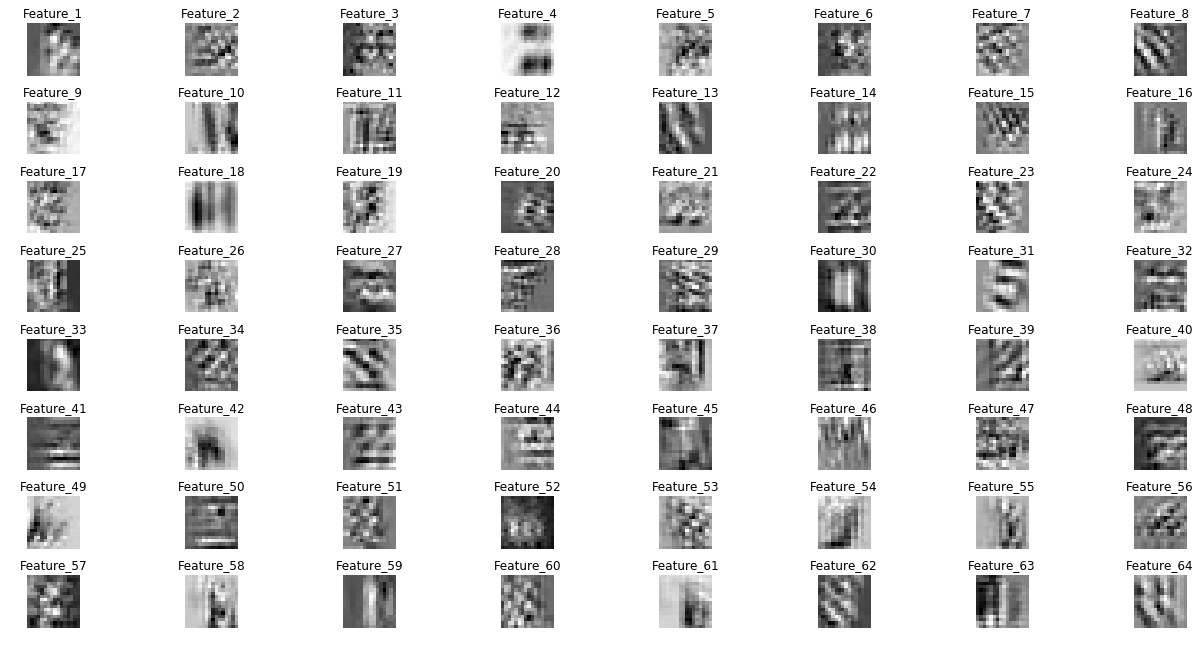

In [23]:
display_features(
                v_name = "conv2/weights:0", 
                pool_size = [None, 8, 8, 64],
                out_shape = [64,16,16,16],
                p_v = p2_v,
                figs = (8,8), 
                col_mp="gray")

After the first feature selection layer, each stack of 16 layers of 16x16 features gets transformed into a stack of 64 features, each of size 8x8. For each of the 64 features, we visualize it by picking the one image (from the stored 64 image batch) that the feature judges best. 

After 2 layers, the information contained in each layer is very limited and abstract. 

* ** Grouping: ** <br>
Feature 4, 18, 30, 59, 63 seem to be 'vertical' features. <br>
<br>
Feature 7, 8, 15, 35, 62 seem to be the 'diagonal' features. <br>
<br>
Feature 31 seems to be targeting specifically the number '5', possibly due to its propensity to get mixed up with other numbers.

#### (iii). Reconstruction From The First Convolutional Layer (one image)

In [11]:
n = 1 #index of the image we select

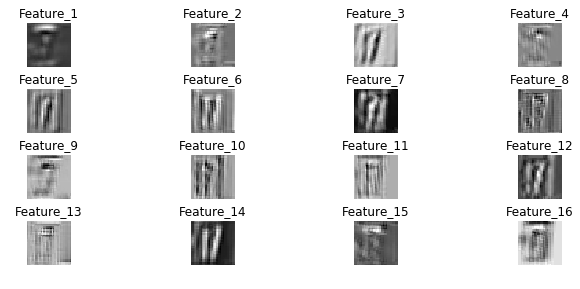

In [18]:
w1 = [v for v in tf.trainable_variables() if v.name == "conv1/weights:0"][0]

#Reconstruction from the layer CNV-1
featuresReLu_1 = tf.placeholder(tf.float32,[None, 16, 16, 16])
unPool_1 = unpool(featuresReLu_1)
unReLu_1 = tf.nn.relu(unPool_1)
unBias_1 = unReLu_1

unConv_1 = tf.nn.conv2d_transpose(unBias_1, w1,
                                  output_shape=[64,32,32,1] ,
                                  strides=[1,1,1,1], padding="SAME")

plt.figure(num='layer1',figsize=(10,8))
for i in range(16):
    isolated = p1_v.copy()
    isolated[:,:,:,:i] = 0
    isolated[:,:,:,i+1:] = 0#These two lines set all other features other than feature i to 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        pixelactive = sess.run(unConv_1, feed_dict={featuresReLu_1: isolated})
    #print(pixelactive.shape) 
    plt.subplot(4,4,i+1)
    plt.imshow(pixelactive[n,:,:,0],cmap="gray")
    plt.title('Feature_{}'.format(i+1))
    plt.axis('off') 
plt.subplots_adjust(top=0.5, bottom=0.08, left=0.10, right=0.95, hspace=0.5,
                    wspace=0.35)
plt.show()

The house number '17' gets represented by 16 features after Layer 1. 

* ** Grouping: ** <br>
Group I: Feature 1, 2, 4, 9, 13, 15, 16. <br>
The number gets blurred by these features <br>
<br>
Group II: Feature 3, 6, 12, 14. <br>
These features best represent the number '17', with the right information perserved (the shape of number 17) and right information discard (the edge on the right-side of '7', for example) <br>
<br>
Group III: Feature 3, 5, 7, 8, 10, 11, 12. <br>
The number '17' gets recognized as a 3-digit number by these features, with the edge on the right-side of the '7' recognized as the third digit. <br>
<br>
* ** Analysis: ** <br>
In Section 3(i), we briefly summarized the 16 features into 3 groups by looking at the images that they judge best, with Group 1 judging 'twisting' 2-digit house numbers, Group 2 judging 'vertical' 2-digit ones, and Group 3 judging 3-digit ones. Cross referencing the grouping in this section with that in Section 3(i), we find that the two groupings correspond to each other surprisingly well.
<br><br>
Here, the Group I (1, 2, 4, 9, 13, 15, 16) correspond to Group 1 (1, 2, 4, 9, 13, 15). In these features, the house number '17' gets blurred into an unrecognizable haze, which is exactly what one would expect from features that target 'twisting' numbers (such as 22). 
<br><br>
Group II (3, 6, 12, 14) correspond to Group 2 (3, 6, 10, 14). In these features, the house number '17' are neatly represented, with the correct information stored (the shape of the number), and the correct infromation discarded (the background). This is also a reasonable result, as Group 2 are the features that best judge 'vertical' 2-digit house numbers, and '17' is a 'vertical' 2-digit house number.
<br><br>
Group III (3, 5, 7, 8, 10, 11, 12) correspond to Group 3 (5, 8, 11, 12). In these features, the edge on the right-side of '7' is incorrectly recognized as a third number '1'. This coincide with our summarization of Group 3, which is that they recogizes 3-digit house numbers that span across the entire image. 

#### (iv). Reconstruction From The Second Convolutional Layer (one image)

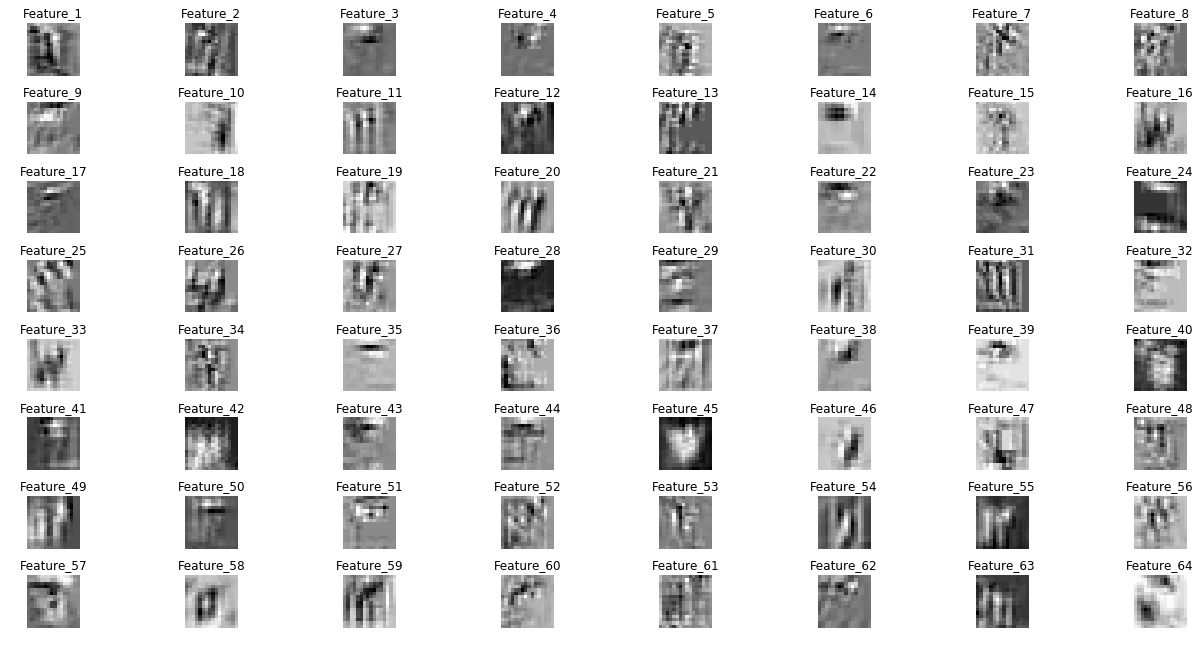

In [21]:
w2 = [v for v in tf.trainable_variables() if v.name == "conv2/weights:0"][0]

#Reconstruction from the layer CNV-2
featuresReLu_2 = tf.placeholder(tf.float32,[None, 8, 8, 64])
unPool_2 = unpool(featuresReLu_2)
unReLu_2 = tf.nn.relu(unPool_2)
unBias_2 = unReLu_2
unConv_2 = tf.nn.conv2d_transpose(unBias_2, w2, output_shape=[64,16,16,16] , strides=[1,1,1,1], padding="SAME")

plt.figure(num='layer2',figsize=(20,20))
for i in range(64):
    isolated = p2_v.copy()
    isolated[:,:,:,:i] = 0
    isolated[:,:,:,i+1:] = 0
    #These two lines set all other features other than feature i to 0
    #print (isolated.shape)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        pixelactive = sess.run(unConv_2, feed_dict={featuresReLu_2: isolated})
    #print(pixelactive.shape) 
    plt.subplot(8,8,i+1)    
    plt.imshow(pixelactive[n,:,:,0],cmap="gray")
    plt.title('Feature_{}'.format(i+1))
    plt.axis('off') 
plt.subplots_adjust(top=0.5, bottom=0.08, left=0.10, right=0.95, hspace=0.5,
                    wspace=0.35)
plt.show()

As in Section 3(ii), the features of house number '17' are perhaps too abstract for human to interpret after Layer 2. However, one could still notice that the number '17' gets represented well by the features that we categorized as 'vertical' ones in Section 3(ii), i.e., Feature 18, 30, 59, 63, etc. 